# Data Collection and EDA

- All detailed codes and data are attached to the submission. For simplicity, we don't include all codes and data here in the website (final report).

In [1]:
import warnings

import sys
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import scatter_matrix

import json

from bs4 import BeautifulSoup
import requests
import time

from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.manifold import MDS


# Spotify
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
client_credentials_manager = SpotifyClientCredentials(client_id='e6ff82a6418a4191a5b3a95622faf5dd', client_secret='a37b632dc07d4136902fa95ec56281d3')
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

# Genius
Genius_TOKEN = 'C2ow8dBpT2W5ORhiqaiz8ht8zLs9UzjFJQS5fwsmkRwWZyj8Wi1dA37FXYjScYuu'

import re

pd.set_option('display.width', 1500) 
pd.set_option('display.max_columns', 100)

## 1. Research on Available Databases

### (1) Million Playlist Dataset

- Million Playlist Dataset is a very large playlist dataset provided by Spotify, particularly prepared for RecSys Challenge 2018 (https://recsys-challenge.spotify.com/). It consists of 1000 files in .json format, and each file contains 1000 user-created playlists, which makes 1 million playlists in 5.4 GB. The dataset was generated in December, 2017.


- Data format:
    - For each playlist, available data are:
        - `name` (string): The name of the playlist.
        - `collaborative` (Boolean): `true` if the owner allows other users to modify the playlist.
        - `pid` (int): Position ID number of the playlist in the dataset (0 - 999999).
        - `modified_at` (timestamp): The timestamp when the playlist was list modified.
        - `num_tracks` (int): The number of tracks in the playlist.
        - `num_albums` (int): The number of unique albums in the playlist.
        - `num_followers` (int): The number of followers of the playlist.
        - `tracks` (dictionary): The list of tracks in the playlist (see below).
        - `num_edits` (int): The number of edits that has been made so far.
        - `duration_ms` (int): The total duration of the playlist in milliseconds.
        - `num_artists` (int): The number of unique artists in the playlist.
    - For each track in a playlist, available data are:
        - `pos` (int): Position ID number of the track in the playlist.
        - `artist_name` (string): The name of the artist of the track.
        - `track_uri` (uri): The URI for the track.
        - `artist_uri` (uri): The URI for the artist of the track.
        - `track_name` (string): The name of the track.
        - `album_uri` (uri): The URI for the album of the track.
        - `duration_ms` (int): The duration of the track in milliseconds.
        - `album_name` (string): The name of the album of the track.


- Below will show an example data format for the 0th playlist in the 0th file (its output is currently hidden):

In [2]:
FILENAME = 'data/mpd.slice.0-999.json'
with open(FILENAME, "r") as fd:
    playlist_data = json.load(fd)
    
playlist_data['playlists'][0]

{'name': 'Throwbacks',
 'collaborative': 'false',
 'pid': 0,
 'modified_at': 1493424000,
 'num_tracks': 52,
 'num_albums': 47,
 'num_followers': 1,
 'tracks': [{'pos': 0,
   'artist_name': 'Missy Elliott',
   'track_uri': 'spotify:track:0UaMYEvWZi0ZqiDOoHU3YI',
   'artist_uri': 'spotify:artist:2wIVse2owClT7go1WT98tk',
   'track_name': 'Lose Control (feat. Ciara & Fat Man Scoop)',
   'album_uri': 'spotify:album:6vV5UrXcfyQD1wu4Qo2I9K',
   'duration_ms': 226863,
   'album_name': 'The Cookbook'},
  {'pos': 1,
   'artist_name': 'Britney Spears',
   'track_uri': 'spotify:track:6I9VzXrHxO9rA9A5euc8Ak',
   'artist_uri': 'spotify:artist:26dSoYclwsYLMAKD3tpOr4',
   'track_name': 'Toxic',
   'album_uri': 'spotify:album:0z7pVBGOD7HCIB7S8eLkLI',
   'duration_ms': 198800,
   'album_name': 'In The Zone'},
  {'pos': 2,
   'artist_name': 'Beyoncé',
   'track_uri': 'spotify:track:0WqIKmW4BTrj3eJFmnCKMv',
   'artist_uri': 'spotify:artist:6vWDO969PvNqNYHIOW5v0m',
   'track_name': 'Crazy In Love',
   'alb

- Notes:
    - As the entire dataset is too large, data resizing (resampling) is required.
    - Although not many types of data are available in the dataset, but it does provide URIs for track, artist, and album for each track, which can be used in Spotify API to query more data (see below).

### (2) Spotify Web API

- Spotify Web API (https://developer.spotify.com/documentation/web-api/) is a developer's tool provided by Spotify, particularly for developing web applications related to Spotify. Based on simple REST principles, the Spotify Web API endpoints return JSON metadata about music artists, albums, and tracks, directly from the Spotify Data Catalogue. Web API also provides access to user related data, like playlists and music that the user saves in the Your Music library. Such access is enabled through selective authorization, by the user. The API provides a set of endpoints, each with its own unique path. To access private data through the Web API, such as user profiles and playlists, an application must get the user's permission to access the data. Authorization is via the Spotify Accounts service.


<img src="https://developer.spotify.com/assets/WebAPI_intro.png" width="600" height="250" align="middle">


- For this project, we have used Spotipy (https://spotipy.readthedocs.io/), which is a lightweight Python library for the Spotify Web API. With Spotipy we can get full access to all of the music data provided by the Spotify platform. Below we list some key function endpoints provided by Spotipy.

- `spotipy.Spotify().track(track_uri)`: Get Spotify catalog information for a single track identified by its unique Spotify ID. (https://developer.spotify.com/documentation/web-api/reference/tracks/get-track/)
    - `album` (a simplified `album object`): The album on which the track appears. The album object includes a link in `href` to full information about the album.
    - `artists` (an array of simplified `artist objects`): The artists who performed the track. Each artist object includes a link in `href` to more detailed information about the artist.
    - `available_markets` (array of strings): A list of the countries in which the track can be played, identified by their `ISO 3166-1 alpha-2 code`.
    - `disc_number` (int): 	The disc number (usually `1` unless the album consists of more than one disc).
    - `duration_ms` (int): The track length in milliseconds.
    - `explicit` (Boolean): Whether or not the track has explicit lyrics (`true` = yes it does; `false` = no it does not OR unknown).
    - `external_ids` (an `external ID object`): Known external IDs for the track.
    - `external_urls` (an `external URL object`): Known external URLs for this track.
    - `href` (string): A link to the Web API endpoint providing full details of the track.
    - `id` (string): The `Spotify ID` for the track.
    - `name` (string): The name of the track.
    - `popularity` (int): The popularity of the track. The value will be between 0 and 100, with 100 being the most popular. The popularity of a track is a value between 0 and 100, with 100 being the most popular. The popularity is calculated by algorithm and is based, in the most part, on the total number of plays the track has had and how recent those plays are. Generally speaking, songs that are being played a lot now will have a higher popularity than songs that were played a lot in the past. Duplicate tracks (e.g. the same track from a single and an album) are rated independently. Artist and album popularity is derived mathematically from track popularity. Note that the popularity value may lag actual popularity by a few days: the value is not updated in real time.
    - `preview_url` (string): A link to a 30 second preview (MP3 format) of the track. Can be `null`.
    - `track_number` (int): The number of the track. If an album has several discs, the track number is the number on the specified disc.
    - `type` (string): The object type, `track`.
    - `uri` (string): The `Spotify URI` for the track.
    
    
- Below will show an example data provided by `spotipy.Spotify().track(track_uri)` for the 0th track in the 0th playlist in the 0th file  (its output is currently hidden):

In [3]:
TRACK_URI = playlist_data['playlists'][0]['tracks'][0]['track_uri']
sp.track(TRACK_URI)

{'album': {'album_type': 'album',
  'artists': [{'external_urls': {'spotify': 'https://open.spotify.com/artist/2wIVse2owClT7go1WT98tk'},
    'href': 'https://api.spotify.com/v1/artists/2wIVse2owClT7go1WT98tk',
    'id': '2wIVse2owClT7go1WT98tk',
    'name': 'Missy Elliott',
    'type': 'artist',
    'uri': 'spotify:artist:2wIVse2owClT7go1WT98tk'}],
  'available_markets': ['AD',
   'AE',
   'AR',
   'AT',
   'AU',
   'BE',
   'BG',
   'BH',
   'BO',
   'BR',
   'CA',
   'CH',
   'CL',
   'CO',
   'CR',
   'CY',
   'CZ',
   'DE',
   'DK',
   'DO',
   'DZ',
   'EC',
   'EE',
   'EG',
   'ES',
   'FI',
   'FR',
   'GB',
   'GR',
   'GT',
   'HK',
   'HN',
   'HU',
   'ID',
   'IE',
   'IL',
   'IS',
   'IT',
   'JO',
   'JP',
   'KW',
   'LB',
   'LI',
   'LT',
   'LU',
   'LV',
   'MA',
   'MC',
   'MT',
   'MX',
   'MY',
   'NI',
   'NL',
   'NO',
   'NZ',
   'OM',
   'PA',
   'PE',
   'PH',
   'PL',
   'PS',
   'PT',
   'PY',
   'QA',
   'RO',
   'SA',
   'SE',
   'SG',
   'SK',
   'SV'

- `spotipy.Spotify().artist(artist_uri)`: Get Spotify catalog information for a single artist identified by their unique Spotify ID. (https://developer.spotify.com/documentation/web-api/reference/artists/get-artist/)
    - `external_urls` (an `external URL object`): Known external URLs for this artist.
    - `followers` (a `followers object`): Information about the followers of the artist.
    - `genres` (array of strings): A list of the genres the artist is associated with. For example: `Prog Rock`, `Post-Grunge`. (If not yet classified, the array is empty.)
    - `href` (string): A link to the Web API endpoint providing full details of the artist.
    - `id` (string): The `Spotify ID` for the artist.
    - `images` (array of `image objects`): Images of the artist in various sizes, widest first.
    - `name` (string): The name of the artist.
    - `popularity` (int): The popularity of the artist. The value will be between 0 and 100, with 100 being the most popular. The artist's popularity is calculated from the popularity of all the artist's tracks.
    - `type` (string): The object type, `artist`.
    - `uri` (string): The `Spotify URI` for the artist.


- Below will show an example data provided by `spotipy.Spotify().artist(artist_uri)` for the artist of the 0th track in the 0th playlist in the 0th file (its output is currently hidden):

In [4]:
ARTIST_URI = playlist_data['playlists'][0]['tracks'][0]['artist_uri']
sp.artist(ARTIST_URI)

{'external_urls': {'spotify': 'https://open.spotify.com/artist/2wIVse2owClT7go1WT98tk'},
 'followers': {'href': None, 'total': 909826},
 'genres': ['dance pop',
  'hip hop',
  'hip pop',
  'pop',
  'pop rap',
  'r&b',
  'rap',
  'southern hip hop',
  'urban contemporary'],
 'href': 'https://api.spotify.com/v1/artists/2wIVse2owClT7go1WT98tk',
 'id': '2wIVse2owClT7go1WT98tk',
 'images': [{'height': 640,
   'url': 'https://i.scdn.co/image/055260c034b93dae018b8cd70bc9f1acc2843af3',
   'width': 640},
  {'height': 320,
   'url': 'https://i.scdn.co/image/2642935f38deb4f2305cabfd996babec8796d469',
   'width': 320},
  {'height': 160,
   'url': 'https://i.scdn.co/image/11323b9db35fb2b10c1676a0eeeb5ff8a4ed32e8',
   'width': 160}],
 'name': 'Missy Elliott',
 'popularity': 76,
 'type': 'artist',
 'uri': 'spotify:artist:2wIVse2owClT7go1WT98tk'}

- `spotipy.Spotify().album(album_uri)`: Get Spotify catalog information for a single album. (https://developer.spotify.com/documentation/web-api/reference/albums/get-album/)
    - `album_type` (string): The type of the album, one of `album`, `single`, or `compilation`.
    - `artists` (array of simplified `artist objects`): The artists of the album. Each artist object includes a link in `href` to more detailed information about the artist.
    - `available_markets` (array of strings): The markets in which the album is available in `ISO 3166-1 alpha-2 country codes`. Note that an album is considered available in a market when at least 1 of its tracks is available in that market.
    - `copyrights` (array of copyright objects): The copyright statements of the album.
    - `external_ids` (an `external ID object`): Known external IDs for the album.
    - `external_urls` (an `external URL object`): Known external URLs for this album.
    - `followers` (a `followers object`): Information about the followers of the artist.
    - `genres` (array of strings): A list of the genres used to classify the album. For example: `Prog Rock`, `Post-Grunge`. (If not yet classified, the array is empty.)
    - `href` (string): A link to the Web API endpoint providing full details of the album.
    - `id` (string): The `Spotify ID` for the album.
    - `images` (array of `image objects`): The cover art for the album in various sizes, widest first.
    - `label` (string): The label for the album.
    - `name` (string): The name of the album. In case of an album takedown, the value may be an empty string.
    - `popularity` (int): The popularity of the album. The value will be between 0 and 100, with 100 being the most popular. The popularity is calculated from the popularity of the album’s individual tracks.
    - `release_date` (string): The date the album was first released, for example `1981-12-15`. Depending on the precision, it might be shown as `1981` or `1981-12`.
    - `release_date_precision` (string): The precision with which release_date value is known, `year`, `month`, or `day`.
    - `tracks` (array of simplified `track objects` inside a `paging object`): The tracks of the album.
    - `type` (string): The object type, `album`.
    - `uri` (string): The `Spotify URI` for the album.


- Below will show an example data provided by `spotipy.Spotify().album(album_uri)` for the album of the 0th track in the 0th playlist in the 0th file (its output is currently hidden:

In [5]:
ALBUM_URI = playlist_data['playlists'][0]['tracks'][0]['album_uri']
sp.album(ALBUM_URI)

{'album_type': 'album',
 'artists': [{'external_urls': {'spotify': 'https://open.spotify.com/artist/2wIVse2owClT7go1WT98tk'},
   'href': 'https://api.spotify.com/v1/artists/2wIVse2owClT7go1WT98tk',
   'id': '2wIVse2owClT7go1WT98tk',
   'name': 'Missy Elliott',
   'type': 'artist',
   'uri': 'spotify:artist:2wIVse2owClT7go1WT98tk'}],
 'available_markets': ['AD',
  'AE',
  'AR',
  'AT',
  'AU',
  'BE',
  'BG',
  'BH',
  'BO',
  'BR',
  'CA',
  'CH',
  'CL',
  'CO',
  'CR',
  'CY',
  'CZ',
  'DE',
  'DK',
  'DO',
  'DZ',
  'EC',
  'EE',
  'EG',
  'ES',
  'FI',
  'FR',
  'GB',
  'GR',
  'GT',
  'HK',
  'HN',
  'HU',
  'ID',
  'IE',
  'IL',
  'IS',
  'IT',
  'JO',
  'JP',
  'KW',
  'LB',
  'LI',
  'LT',
  'LU',
  'LV',
  'MA',
  'MC',
  'MT',
  'MX',
  'MY',
  'NI',
  'NL',
  'NO',
  'NZ',
  'OM',
  'PA',
  'PE',
  'PH',
  'PL',
  'PS',
  'PT',
  'PY',
  'QA',
  'RO',
  'SA',
  'SE',
  'SG',
  'SK',
  'SV',
  'TH',
  'TN',
  'TR',
  'TW',
  'US',
  'UY',
  'VN',
  'ZA'],
 'copyrights': [{'t

- `spotipy.Spotify().audio_features(track_uri)`: Get audio feature information for a single track identified by its unique Spotify ID. (https://developer.spotify.com/documentation/web-api/reference/tracks/get-audio-features/)
    - `danceability` (float): Danceability describes how suitable a track is for dancing based on a combination of musical elements including tempo, rhythm stability, beat strength, and overall regularity. A value of 0.0 is least danceable and 1.0 is most danceable.
    
    <img src="https://developer.spotify.com/assets/audio/danceability.png" width="600" height="250" align="middle">
    
    - `energy` (float): Energy is a measure from 0.0 to 1.0 and represents a perceptual measure of intensity and activity. Typically, energetic tracks feel fast, loud, and noisy. For example, death metal has high energy, while a Bach prelude scores low on the scale. Perceptual features contributing to this attribute include dynamic range, perceived loudness, timbre, onset rate, and general entropy.
    
    <img src="https://developer.spotify.com/assets/audio/energy.png" width="600" height="250" align="middle">
    
    - `Key` (int): The estimated overall key of the track. Integers map to pitches using standard `Pitch Class notation`. E.g. 0 = C, 1 = C♯/D♭, 2 = D, and so on. If no key was detected, the value is -1.
    - `loudness` (float): The overall loudness of a track in decibels (dB). Loudness values are averaged across the entire track and are useful for comparing relative loudness of tracks. Loudness is the quality of a sound that is the primary psychological correlate of physical strength (amplitude). Values typical range between -60 and 0 db.
    
    <img src="https://developer.spotify.com/assets/audio/loudness.png" width="600" height="250" align="middle">
    
    - `mode` (int): Mode indicates the modality (major or minor) of a track, the type of scale from which its melodic content is derived. Major is represented by 1 and minor is 0.
    - `speechiness` (float): Speechiness detects the presence of spoken words in a track. The more exclusively speech-like the recording (e.g. talk show, audio book, poetry), the closer to 1.0 the attribute value. Values above 0.66 describe tracks that are probably made entirely of spoken words. Values between 0.33 and 0.66 describe tracks that may contain both music and speech, either in sections or layered, including such cases as rap music. Values below 0.33 most likely represent music and other non-speech-like tracks.
    
    <img src="https://developer.spotify.com/assets/audio/speechiness.png" width="600" height="250" align="middle">
    
    - `acousticness` (float): A confidence measure from 0.0 to 1.0 of whether the track is acoustic. 1.0 represents high confidence the track is acoustic.
    
    <img src="https://developer.spotify.com/assets/audio/acousticness.png" width="600" height="250" align="middle">
    
    - `instrumentalness` (float): Predicts whether a track contains no vocals. “Ooh” and “aah” sounds are treated as instrumental in this context. Rap or spoken word tracks are clearly “vocal”. The closer the instrumentalness value is to 1.0, the greater likelihood the track contains no vocal content. Values above 0.5 are intended to represent instrumental tracks, but confidence is higher as the value approaches 1.0.
    
    <img src="https://developer.spotify.com/assets/audio/instrumentalness.png" width="600" height="250" align="middle">
    
    - `liveness` (float): Detects the presence of an audience in the recording. Higher liveness values represent an increased probability that the track was performed live. A value above 0.8 provides strong likelihood that the track is live.
    
    <img src="https://developer.spotify.com/assets/audio/liveness.png" width="600" height="250" align="middle">
    
    - `valence` (float): A measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track. Tracks with high valence sound more positive (e.g. happy, cheerful, euphoric), while tracks with low valence sound more negative (e.g. sad, depressed, angry).
    
    <img src="https://developer.spotify.com/assets/audio/valence.png" width="600" height="250" align="middle">
    
    - `tempo` (float): The overall estimated tempo of a track in beats per minute (BPM). In musical terminology, tempo is the speed or pace of a given piece and derives directly from the average beat duration.
    
    <img src="https://developer.spotify.com/assets/audio/tempo.png" width="600" height="250" align="middle">
    
    - `type` (string): The object type, `audio_features`.
    - `id` (string): The `Spotify ID` for the track.
    - `uri` (string): The `Spotify URI` for the track.
    - `track_href` (string): A link to the Web API endpoint providing full details of the track.
    - `analysis_url` (string): An HTTP URL to access the full audio analysis of this track. An access token is required to access this data.
    - `duration_ms` (int): The duration of the track in milliseconds.
    - `time_signature` (int): An estimated overall time signature of a track. The time signature (meter) is a notational convention to specify how many beats are in each bar (or measure).


- Below shows an example data provided by `spotipy.Spotify().audio_features(track_uri)` for the 0th track in the 0th playlist in the 0th file:

In [6]:
TRACK_URI = playlist_data['playlists'][0]['tracks'][0]['track_uri']
sp.audio_features(TRACK_URI)

[{'danceability': 0.904,
  'energy': 0.813,
  'key': 4,
  'loudness': -7.105,
  'mode': 0,
  'speechiness': 0.121,
  'acousticness': 0.0311,
  'instrumentalness': 0.00697,
  'liveness': 0.0471,
  'valence': 0.81,
  'tempo': 125.461,
  'type': 'audio_features',
  'id': '0UaMYEvWZi0ZqiDOoHU3YI',
  'uri': 'spotify:track:0UaMYEvWZi0ZqiDOoHU3YI',
  'track_href': 'https://api.spotify.com/v1/tracks/0UaMYEvWZi0ZqiDOoHU3YI',
  'analysis_url': 'https://api.spotify.com/v1/audio-analysis/0UaMYEvWZi0ZqiDOoHU3YI',
  'duration_ms': 226864,
  'time_signature': 4}]

- `spotipy.Spotify().artist_related_artists(artist_uri)`: Get Spotify catalog information about artists similar to a given artist. Similarity is based on analysis of the Spotify community's listening history.
(https://developer.spotify.com/documentation/web-api/reference/artists/get-related-artists/)
    - `artists` (array of `artist objects`): Up to 20 related artists to the artist.


- Below will show an example data provided by `spotipy.Spotify().artist_related_artists(artist_uri)` for the artist of the 0th track in the 0th playlist in the 0th file (its output is currently hidden):

In [7]:
ARTIST_URI = playlist_data['playlists'][0]['tracks'][0]['artist_uri']
sp.artist_related_artists(ARTIST_URI)

{'artists': [{'external_urls': {'spotify': 'https://open.spotify.com/artist/5tth2a3v0sWwV1C7bApBdX'},
   'followers': {'href': None, 'total': 516353},
   'genres': ['dance pop',
    'east coast hip hop',
    'escape room',
    'hip hop',
    'hip pop',
    'pop',
    'pop rap',
    'r&b',
    'rap',
    'southern hip hop',
    'trap queen',
    'urban contemporary'],
   'href': 'https://api.spotify.com/v1/artists/5tth2a3v0sWwV1C7bApBdX',
   'id': '5tth2a3v0sWwV1C7bApBdX',
   'images': [{'height': 1000,
     'url': 'https://i.scdn.co/image/32f4515ff2426fe1e2256cadef56783bfaeb52bd',
     'width': 1000},
    {'height': 640,
     'url': 'https://i.scdn.co/image/40aa4f887d48a0084bbfe2bb7a15f12d1cff5c13',
     'width': 640},
    {'height': 200,
     'url': 'https://i.scdn.co/image/64eed06bbf737e87addaacdaf3a4a0dc97af698c',
     'width': 200},
    {'height': 64,
     'url': 'https://i.scdn.co/image/bdaf058a1e6cfaa3f38911aa02d8ef936702ffee',
     'width': 64}],
   'name': "Lil' Kim",
   'popul

- `spotipy.Spotify().artist_top_tracks(artist_uri)`: Get Spotify catalog information about an artist’s top tracks by country.
(https://developer.spotify.com/documentation/web-api/reference/artists/get-artists-top-tracks)
    - `tracks` (array of `track objects`): Up to 10 top tracks of the artist.


- Below will show an example data provided by `spotipy.Spotify().artist_top_tracks(artist_uri)` for the artist of the 0th track in the 0th playlist in the 0th file (its output is currently hidden):

In [8]:
ARTIST_URI = playlist_data['playlists'][0]['tracks'][0]['artist_uri']
sp.artist_top_tracks(ARTIST_URI)

{'tracks': [{'album': {'album_type': 'album',
    'artists': [{'external_urls': {'spotify': 'https://open.spotify.com/artist/2wIVse2owClT7go1WT98tk'},
      'href': 'https://api.spotify.com/v1/artists/2wIVse2owClT7go1WT98tk',
      'id': '2wIVse2owClT7go1WT98tk',
      'name': 'Missy Elliott',
      'type': 'artist',
      'uri': 'spotify:artist:2wIVse2owClT7go1WT98tk'}],
    'external_urls': {'spotify': 'https://open.spotify.com/album/20t54K6C80QQH7vbcpfJcP'},
    'href': 'https://api.spotify.com/v1/albums/20t54K6C80QQH7vbcpfJcP',
    'id': '20t54K6C80QQH7vbcpfJcP',
    'images': [{'height': 633,
      'url': 'https://i.scdn.co/image/c94d87f743f11254bdd0ffc5434b59dba851d7d6',
      'width': 640},
     {'height': 297,
      'url': 'https://i.scdn.co/image/0507be05842344647ef44aedd1ccd1f0eaa1e17f',
      'width': 300},
     {'height': 63,
      'url': 'https://i.scdn.co/image/462dd41dd28fd3d7a4e74c24ef542c7e5db2f384',
      'width': 64}],
    'name': 'Miss E...So Addictive',
    'releas

- Notes:
  - There may be high multicollinearity in these data, as these are a mix of primary and secondary information. For example, Spotify Web API explains that the danceability is based on other primary data including tempo, while the energy is based on some other primary data including loudness. Therefore, it would be important to find a method that are insensitive to the multicollinearity among columns.

### (3) Genius API

- Genius (https://genius.com/) is an American digital media library, particularly specialized for song lyrics and musical knowledge. Genius provides public Genius API where we can access lyrics data for songs.


- Below shows a screen capture of https://genius.com/Missy-elliott-lose-control-lyrics, which is the 0th track in the 0th playlist in the 0th file, along with the developer tool.


<img src="https://raw.githubusercontent.com/slee25/AC209A_SpotifyGroup30/master/notebooks/fig/Genius.png" width="635" height="460"  align="middle">



- Below will show a html-parsed result of this page by using `requests` and `BeautifulSoup` (its output is currently hidden):

In [9]:
GeniusURL = "https://genius.com/Missy-elliott-lose-control-lyrics"
BeautifulSoup(requests.get(GeniusURL).text,'html.parser')


<!DOCTYPE html>

<html class="snarly apple_music_player--enabled bagon_song_page--enabled song_stories_public_launch--enabled" lang="en" xml:lang="en" xmlns="http://www.w3.org/1999/xhtml" xmlns:fb="http://www.facebook.com/2008/fbml">
<head>
<base href="//genius.com/" target="_top"/>
<script type="text/javascript">
//<![CDATA[

  var _sf_startpt=(new Date()).getTime();
  if (window.performance && performance.mark) {
    window.performance.mark('parse_start');
  }

//]]>
</script>
<title>Missy Elliott – Lose Control Lyrics | Genius Lyrics</title>
<meta content="text/html; charset=utf-8" http-equiv="Content-Type"/>
<meta content="width=device-width,initial-scale=1" name="viewport"/>
<meta content="app-id=709482991" name="apple-itunes-app"/>
<link href="https://assets.genius.com/images/apple-touch-icon.png?1544632201" rel="apple-touch-icon"/>
<link href="https://assets.genius.com/images/apple-touch-icon.png?1544632201" rel="apple-touch-icon"/>
<!-- Mobile IE allows us to activate ClearTyp

- Using Genius API, this information is more easily accessible (its output is currently hidden):

In [10]:
GeniusAPIURL = 'https://api.genius.com/search'
BeautifulSoup(requests.get(GeniusAPIURL, data={'q': 'Lose Control Missy Elliott'}, headers={'Authorization': 'Bearer ' + Genius_TOKEN}).text, 'html.parser')

{"meta":{"status":200},"response":{"hits":[{"highlights":[],"index":"song","type":"song","result":{"annotation_count":7,"api_path":"/songs/33158","full_title":"Lose Control by Missy Elliott (Ft. Ciara &amp; Fatman Scoop)","header_image_thumbnail_url":"https://images.genius.com/51639e476eac5cb5bed5794c023763ff.300x303x1.jpg","header_image_url":"https://images.genius.com/51639e476eac5cb5bed5794c023763ff.700x707x1.jpg","id":33158,"lyrics_owner_id":50,"lyrics_state":"complete","path":"/Missy-elliott-lose-control-lyrics","pyongs_count":8,"song_art_image_thumbnail_url":"https://images.genius.com/51639e476eac5cb5bed5794c023763ff.300x303x1.jpg","stats":{"hot":false,"unreviewed_annotations":2,"pageviews":55665},"title":"Lose Control","title_with_featured":"Lose Control (Ft. Ciara &amp; Fatman Scoop)","url":"https://genius.com/Missy-elliott-lose-control-lyrics","primary_artist":{"api_path":"/artists/1529","header_image_url":"https://images.genius.com/fc183acc7f3e70189a76afe4a0d8cdf7.240x320x1.jp

### (4) Lyrics Wiki

- Lyrics Wiki (http://lyrics.wikia.com/wiki/LyricWiki) is a large database for lyrics. Lyrics for a certain song can be scraped at http://lyrics.wikia.com/wiki/[artist_name]:[track_name].


- Below shows a screen capture of http://lyrics.wikia.com/wiki/Missy_Elliott:Lose_Control, which is the 0th track in the 0th playlist in the 0th file, along with the developer tool.

<img src="https://raw.githubusercontent.com/slee25/AC209A_SpotifyGroup30/master/notebooks/fig/LyricsWiki.png" width="635" height="460"  align="middle">



- Below shows a html-parsed result of this page by using `requests` and `BeautifulSoup` (its output is currently hidden):

In [11]:
LyricsWikiURL = "http://lyrics.wikia.com/wiki/Missy_Elliott:Lose_Control"
BeautifulSoup(requests.get(LyricsWikiURL).text,'html.parser')

<!DOCTYPE doctype html>

<html class="" dir="ltr" lang="en">
<head>
<meta content="text/html; charset=utf-8" http-equiv="Content-Type"/>
<meta content="width=device-width, user-scalable=yes" name="viewport"/>
<meta content="MediaWiki 1.19.24" name="generator">
<meta content="Lose Control lyrics,Missy Elliott Lose Control lyrics,Lose Control by Missy Elliott lyrics,lyrics,LyricWiki,LyricWiki,lyricwiki,Missy Elliott:Lose Control,Missy Elliott,Missy Elliott:The Cookbook (2005),Missy Elliott:Lose Control,Language/English" name="keywords">
<meta content="Lose Control This song is by Missy Elliott and appears on the album The Cookbook (2005). (Hot Streak - Body Work Sample) Music make you lose control, Music make you lose control. (Fatman Scoop) Let&amp;amp;#39;s go. Hey, yeah, yeah, yeah, yeah, yeah. Here we go now, Here we go now, Here we go now, Here..." name="description"/>
<meta content="summary" name="twitter:card"/>
<meta content="@getfandom" name="twitter:site"/>
<meta content="http:

## 2. Data Resampling

- As mentioned earlier, the Million Playlist Dataset is too large to handle, we have decided to resize/resample the data.

- We have decided to sample 1000 playlists among the 1 million playlists, and the selection criteria were as follows:
    - The number of followers should be equal or greater than 20.
        - If the number of followers is too few, e.g. 1 only the person who created the playlist, the taste of the playlist might be highly biased and/or inconsistent. To ensure the consistency and generalizability, we set a lower bound to the number of followers.
    - The number of tracks should be greater than 55.
        - If there are too few number of tracks in a playlist, it would be very hard to split the train and test sets, preventing meaningful predictions. We set the minimum size of both training and test sets as 25, with margin 5, so the minimum number of tracks was determined as 55.
    - Among the playlists that meets the criteria above, randomly sample 1000 playlists.
        - We may select 1000 playlists in the order of the number of followers, but in this way, the samples may also be biased by having too popular musics only.

- The `playlist_stat.npy` below contains pre-prepared data (separate ipynb and pdf are attached: `Data_Collection_EDA_Section2.ipynb`) for the number of followers and the number of tracks in the Million Playlist:

In [12]:
playlist_stat = np.load('data/playlist_stat.npy')

- The distribution of the number of tracks in a playlist for the Million Playlist Dataset is like below:

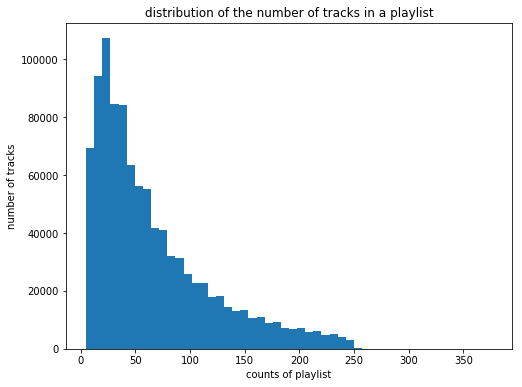

20.0

In [13]:
plt.figure(figsize=[8,6])
plt.hist(playlist_stat[:,4],bins=50)
plt.title('distribution of the number of tracks in a playlist')
plt.xlabel('counts of playlist')
plt.ylabel('number of tracks')
plt.show()

from statistics import mode
mode(playlist_stat[:,4])

- Thus, the number of tracks in a playlist shows a right-skewed distribution and the most fequent number is 20.

- Similarly, the distribution of the number of followers of a playlists for the Million Playlist Dataset is like below:

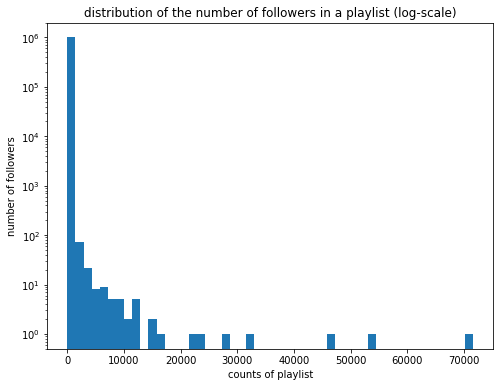

In [14]:
plt.figure(figsize=[8,6])
plt.hist(playlist_stat[:,3], bins=50, log=True)
plt.title('distribution of the number of followers in a playlist (log-scale)')
plt.xlabel('counts of playlist')
plt.ylabel('number of followers')
plt.show()

- Note that, this is in log scale. As shown, a majority of the playlists has 1 follower (the creater of the playlist themselves), and only few playlists has 10000+ followers.

- Based on the criteria above, we've sampled playlists that have 55+ tracks, and eligible playlists are 447703 playlists out of 1 million.

In [15]:
playlist_stat_55 = playlist_stat[playlist_stat[:,4]>55,:]
playlist_stat_55.shape[0]

447703

- Among the 447703 playlists selected, depending on the number of followers that we select as the lower bound, the final number of eligible playlists is like below:

In [16]:
print('[followers]\t[playlists]')
print(40, '\t\t', sum(playlist_stat_55[:,3]>=40))
print(30, '\t\t', sum(playlist_stat_55[:,3]>=30))
print(20, '\t\t', sum(playlist_stat_55[:,3]>=20))
print(10, '\t\t', sum(playlist_stat_55[:,3]>=10))
print(5, '\t\t', sum(playlist_stat_55[:,3]>=5))

[followers]	[playlists]
40 		 919
30 		 1211
20 		 1852
10 		 5070
5 		 20726


- This indicates that, if we select the lower bound of the number of followers as 20 based on the criteria above, 1852 playlists out of 1 million will be eligible. We believe 1852 to 1000 is a reasonable down-sampling rate, so we sampled 1000 playlists among these 1852 playlists by using `np.random.seed(0)` and `np.random.choice` (separate ipynb and pdf are attached: `Data_Collection_EDA_Section2.ipynb`).

## 3. Scaping and Constructing Data Structure

### (1) Initial Data Structure from Million Playlist Dataset

- After sampling 1000 playlists out of eligible 1852 playlists, we constructed initial data structure as a Pandas DataFrame. The initial data structure contains all the information provided by the Million Playlist Dataset.
    - For each playlist, available data are:
        - `name` (string): The name of the playlist.
        - `collaborative` (Boolean): `true` if the owner allows other users to modify the playlist.
        - `pid` (int): Position ID number of the playlist in the dataset (0 - 999999).
        - `modified_at` (timestamp): The timestamp when the playlist was list modified.
        - `num_tracks` (int): The number of tracks in the playlist.
        - `num_albums` (int): The number of unique albums in the playlist.
        - `num_followers` (int): The number of followers of the playlist.
        - `tracks` (dictionary): The list of tracks in the playlist (see below).
        - `num_edits` (int): The number of edits that has been made so far.
        - `duration_ms` (int): The total duration of the playlist in milliseconds.
        - `num_artists` (int): The number of unique artists in the playlist.
    - For each track in a playlist, available data are:
        - `pos` (int): Position ID number of the track in the playlist.
        - `artist_name` (string): The name of the artist of the track.
        - `track_uri` (uri): The URI for the track.
        - `artist_uri` (uri): The URI for the artist of the track.
        - `track_name` (string): The name of the track.
        - `album_uri` (uri): The URI for the album of the track.
        - `duration_ms` (int): The duration of the track in milliseconds.
        - `album_name` (string): The name of the album of the track.
- For each playlist, we select the first 55 tracks, so that all playlists have the same contribution to the model. This will makes the number of tracks 550000.

- The `playlists_df_short.pkl` below contains pre-prepared data (separate ipynb and pdf are attached: `Data_Collection_EDA_Section3-1.ipynb`) for initial data structure contains 550000 tracks from the 1000 playlists.

In [17]:
playlists_df_short = pd.read_pickle('data/playlists_df_short.pkl')
display(playlists_df_short.head())
display(playlists_df_short.describe())
display(playlists_df_short.shape)

,album_name,album_uri,artist_name,artist_uri,collaborative,description,duration_ms,modified_at,name,num_albums,num_artists,num_edits,num_followers,num_tracks,pid,playlist_duration_ms,pos,track_name,track_uri
0,127 Hours,spotify:album:70wOJPVD0SKMn0DtddtZP3,Free Blood,spotify:artist:58cwi0vXDQEihBLREQTBGG,false,,351640,1492992000,BIKING,97,93,67,31,100,391407,24415031,0,Never Hear Surf Music Again,spotify:track:0PxPcrfAXNu0MpKRwdlbuc
1,Waves,spotify:album:2R6wefBXnMzCkRoqD7FdNk,Joey Bada$$,spotify:artist:2P5sC9cVZDToPxyomzF1UH,false,,213333,1492992000,BIKING,97,93,67,31,100,391407,24415031,1,Waves,spotify:track:1fb6b2Mas9q2mWxJazzeRI
2,Every Kingdom,spotify:album:2MxcbOGFi99D9JACvj74AH,Ben Howard,spotify:artist:5schNIzWdI9gJ1QRK8SBnc,false,,309346,1492992000,BIKING,97,93,67,31,100,391407,24415031,2,The Wolves,spotify:track:3gqP2hxwgi6mb8FhtEe4zU
3,Wasting Light,spotify:album:5lnQLEUiVDkLbFJHXHQu9m,Foo Fighters,spotify:artist:7jy3rLJdDQY21OgRLCZ9sD,false,,286466,1492992000,BIKING,97,93,67,31,100,391407,24415031,3,Bridge Burning,spotify:track:0bHD1nLe7Nhw55ZGJ92332
4,Sweet Disarray,spotify:album:2qg3JERQKBjZXvMBtvKR0y,Dan Croll,spotify:artist:5Rr15NSbi1Xjno1AEP9u21,false,,196848,1492992000,BIKING,97,93,67,31,100,391407,24415031,4,From Nowhere,spotify:track:5c9YHjSjEZxaCxsF1Gy5Jt


,duration_ms,modified_at,num_albums,num_artists,num_edits,num_followers,num_tracks,pid,playlist_duration_ms,pos
count,5.500000e+04,5.500000e+04,55000.000000,55000.00000,55000.000000,55000.000000,55000.000000,55000.000000,5.500000e+04,55000.000000
mean,2.350665e+05,1.481653e+09,88.700000,64.90000,38.719000,471.814000,126.793000,497957.939000,2.964576e+07,27.000000
std,7.615811e+04,3.638871e+07,46.491755,37.78886,32.297601,2867.397217,53.436149,287955.184373,1.318153e+07,15.874652
min,2.060000e+02,1.298765e+09,4.000000,3.00000,2.000000,20.000000,56.000000,1923.000000,9.243679e+06,0.000000
25%,1.968930e+05,1.468260e+09,55.000000,40.00000,12.000000,25.000000,81.000000,256333.750000,1.872908e+07,13.000000
50%,2.251460e+05,1.498046e+09,81.000000,60.00000,32.000000,39.000000,115.500000,495125.000000,2.681876e+07,27.000000
75%,2.611548e+05,1.507615e+09,117.000000,86.25000,54.000000,104.000000,166.000000,742869.750000,3.841217e+07,41.000000
max,4.504400e+06,1.509494e+09,234.000000,194.00000,179.000000,53519.000000,250.000000,997547.000000,9.654618e+07,54.000000


(55000, 19)

- As shown, the initial data structure contains 55000 track data (1000 playlists * 55 tracks/playlist), and the number of columns is 19, but only 10 of them are numeric, indicating there are not enough numeric data to build model and make prediction.

### (2) Data Scraping from Spotify API

- As mentioned above, by using `album_uri`, `artist_uri`, and `track_uri` in the intial data structure, we can scrape more data using Spotify API. We have created custom python functions to scrape information using different Spotify API function endpoints.

- `AddAudioFeatures`: adds `danceability`, `energy`, `key`, `loudness`, `mode`, `speechiness`, `acousticness`, `instrumentalness`, `liveness`, `valence`, `tempo`, and `time_signature` of the track by using `spotipy.Spotify().audio_features(track_uri)`:

In [18]:
def AddAudioFeatures(df, ind, sp):
    try:
        audio_feature = sp.audio_features(df.loc[ind]['track_uri'])[0]
    except:
        print('No ID at ' + str(ind))
    else:
        feature_list = ['danceability','energy','key','loudness','mode','speechiness','acousticness',
                        'instrumentalness','liveness','valence','tempo','time_signature']

        for feature in feature_list:
            df.at[ind, feature] = audio_feature[feature]

- `AddTrackPopularity`: adds `popularity` of the track by using `spotipy.Spotify().track(track_uri)`:

In [19]:
def AddTrackPopularity(df, ind, sp):
    try:
        track_info = sp.track(df.loc[ind]['track_uri'])
    except:
        print('No ID at ' + str(ind))
    else:
        df.at[ind, 'popularity'] = track_info['popularity']

- `AddArtistGenres`: adds genres of the artist with one-hot encoding using `spotipy.Spotify().artist(artist_uri)`. Note that this is genres of the artist, not of the track, as the Spotify API doesn't provide genre for each track. Also, note that as a list of genres, we used `spotipy.Spotify().recommendation_genre_seeds()['genres']`, which contains names of 126 basic genres.

In [20]:
def AddArtistGenres(df, ind, sp):
    try:
        artist_info = sp.artist(df.loc[ind]['artist_uri'])
    except:
        print('No ID at ' + str(ind))
    else:
        genre_list = sp.recommendation_genre_seeds()['genres']

        for gen in genre_list:
            if gen in artist_info['genres']:
                df.at[ind, gen] = 1
            else:
                df.at[ind, gen] = 0

- `AddAlbumYear`: adds the year when the album came out using `spotipy.Spotify().album(album_uri)`. Note that Spotify API provides the `release_date` in `YYYY-MM-DD` form, so the first part of the string is converted into an integer.

In [21]:
def AddAlbumYear(df, ind, sp):
    try:
        album_info = sp.album(df.loc[ind]['album_uri'])
    except:
        print('No ID at ' + str(ind))
    else:
        df.at[ind, 'year'] = int(album_info['release_date'].split('-')[0])

- `AddTopTracks`: adds the number of top tracks of the artist as well as URIs of all of the top tracks using `spotipy.Spotify().artist_top_tracks(artist_uri)`. If the number of top tracks is less than 10, the remainings will be filled with blank.

In [22]:
def AddTopTracks(df, ind, sp):    
    try:
        top_track_info = sp.artist_top_tracks(df.loc[ind]['artist_uri'])['tracks']
    except:
        print('\n No ID at ' + str(ind) + '\n')
        print(df.loc[ind]['artist_uri'])
    else:
        n = len(top_track_info)
        df.at[ind, 'top_track_n'] = n
        
        for i in range(10):
            if i in range(n):
                df.at[ind, 'top_track_'+str(i)] = top_track_info[i]['uri']
            else:
                df.at[ind, 'top_track_'+str(i)] = ''

- AddRelatedArtists: adds the number of related artists of the artist as well as URIs of all of the related artists using `spotipy.Spotify().artist_related_artists(artist_uri)`. If the number of related artists is less than 20, the remainings will be filled with blank.

In [23]:
def AddRelatedArtists(df, ind, sp):
    try:
        related_artist_info = sp.artist_related_artists(df.loc[ind]['artist_uri'])['artists']
    except:
        print('\n No ID at ' + str(ind) + '\n')
        print(df.loc[ind]['artist_uri'])
    else:
        n = len(related_artist_info)
        df.at[ind, 'related_artist_n'] = n
        
        for i in range(20):
            if i in range(n):
                df.at[ind, 'related_artist_'+str(i)] = related_artist_info[i]['uri']
            else:
                df.at[ind, 'related_artist_'+str(i)] = ''

### (3) Data Scraping from Genius API and Lyrics Wiki

- As mentioned above, by scraping Genius API and Lyrics Wiki, we can get lyrics data where we can get more information by using natural language processing. As both database have many missing data, we have used both databases to minimize the possibility of missing data.


- Of note, unlike Spotify API where we can directly use the URIs for the track, artist, and albums, for lyrics we had to rely on search query given to the databases. Thus, we have tried as many as possible combinations of the search terms and have tried to deal with special cases (special letters, languages other than English, etc.). Thus, this part of the code is quite long and messy, so we decide to not include here, but we attach as separate files.


- The `playlists_df_full_section3_3.pkl` below contains pre-prepared data (separate ipynb and pdf are attached: `Data_Collection_EDA_Section3-2-1.ipynb` and `Data_Collection_EDA_Section3-3.ipynb`) for final data structure contains 550000 tracks with all scraped data.

In [24]:
playlists_df_full_section3_3 = pd.read_pickle('data/playlists_df_full_section3_3.pkl')
display(playlists_df_full_section3_3.head())
display(playlists_df_full_section3_3.describe())
display(playlists_df_full_section3_3.shape)

,acoustic,acousticness,afrobeat,album_name,album_uri,alt-rock,alternative,ambient,anime,artist_name,artist_uri,black-metal,bluegrass,blues,bossanova,brazil,breakbeat,british,cantopop,chicago-house,children,chill,classical,club,collaborative,comedy,country,dance,danceability,dancehall,death-metal,deep-house,description,detroit-techno,disco,disney,drum-and-bass,dub,dubstep,duration_ms,edm,electro,electronic,emo,energy,folk,forro,french,funk,garage,...,related_artist_9,related_artist_n,road-trip,rock,rock-n-roll,rockabilly,romance,sad,salsa,samba,sertanejo,show-tunes,singer-songwriter,ska,sleep,songwriter,soul,soundtracks,spanish,speechiness,study,summer,swedish,synth-pop,tango,techno,tempo,time_signature,top_track_0,top_track_1,top_track_2,top_track_3,top_track_4,top_track_5,top_track_6,top_track_7,top_track_8,top_track_9,top_track_n,track_name,track_uri,trance,trial,trip-hop,try_idx,turkish,valence,work-out,world-music,year
0,0.0,0.011400,0.0,127 Hours,spotify:album:70wOJPVD0SKMn0DtddtZP3,0.0,0.0,0.0,0.0,Free Blood,spotify:artist:58cwi0vXDQEihBLREQTBGG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,false,0.0,0.0,0.0,0.775,0.0,0.0,0.0,,0.0,0.0,0.0,0.0,0.0,0.0,351640,0.0,0.0,0.0,0.0,0.828,0.0,0.0,0.0,0.0,0.0,...,spotify:artist:6P4lf0XbkcwHMRlkTI5ACo,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0503,0.0,0.0,0.0,0.0,0.0,0.0,108.016,4.0,spotify:track:3ihS3VFJaMoOiGnqNQkofK,spotify:track:2cAlHfVD1Q2wEU6uwipRvc,spotify:track:3PVBYmDOolNqNWQcrY85zn,spotify:track:6eqyr38v77Y13G2EPX2Njl,spotify:track:09H8bis4vzY3jEsVy5KYfF,spotify:track:4GRLoSad0HeAkdKuysxZ87,spotify:track:2C9UMgOxNro5N97v2ytzZu,,,,7.0,Never Hear Surf Music Again,spotify:track:0PxPcrfAXNu0MpKRwdlbuc,0.0,0.0,0.0,0.0,0.0,0.531,0.0,0.0,2010.0
1,0.0,0.094400,0.0,Waves,spotify:album:2R6wefBXnMzCkRoqD7FdNk,0.0,0.0,0.0,0.0,Joey Bada$$,spotify:artist:2P5sC9cVZDToPxyomzF1UH,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,false,0.0,0.0,0.0,0.591,0.0,0.0,0.0,,0.0,0.0,0.0,0.0,0.0,0.0,213333,0.0,0.0,0.0,0.0,0.892,0.0,0.0,0.0,0.0,0.0,...,spotify:artist:7BMccF0hQFBpP6417k1OtQ,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2930,0.0,0.0,0.0,0.0,0.0,0.0,89.849,4.0,spotify:track:4ntsD33Pgsgk8rUyZLLiUV,spotify:track:4txpZk7WSjV1dsZAw5WYcT,spotify:track:7L9g4cPfohScjJ8mGwLQWr,spotify:track:2ZVRyUFQTI5K99wpJElGrD,spotify:track:6xz04ypw5JsqiyityCASG1,spotify:track:6lM1G8kF3xCUW20lIRfoBm,spotify:track:5URYXSFGks9Q8eYePlgVdL,spotify:track:7g8rz7xe0G4Go0tTZAXcOx,spotify:track:2DP3SfAM8g1hKPXKWyDptv,spotify:track:5csdNgCD64XzhsyoRlhzsa,10.0,Waves,spotify:track:1fb6b2Mas9q2mWxJazzeRI,0.0,0.0,0.0,0.0,0.0,0.712,0.0,0.0,2012.0
2,0.0,0.312000,0.0,Every Kingdom,spotify:album:2MxcbOGFi99D9JACvj74AH,0.0,0.0,0.0,0.0,Ben Howard,spotify:artist:5schNIzWdI9gJ1QRK8SBnc,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,false,0.0,0.0,0.0,0.496,0.0,0.0,0.0,,0.0,0.0,0.0,0.0,0.0,0.0,309346,0.0,0.0,0.0,0.0,0.531,0.0,0.0,0.0,0.0,0.0,...,spotify:artist:2LSJrlndCuTpdEluvYHc2E,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0325,0.0,0.0,0.0,0.0,0.0,0.0,119.159,4.0,spotify:track:2uhEKg8kIzpdvz4gyy6x8W,spotify:track:3CAX47TnPqTujLIQTw8nwI,spotify:track:5fpEDGQX0Ah3utGnFYulQZ,spotify:track:4qyfir5Yr7nfo05g6cyFMT,spotify:track:7gYwIAHB6VxzLJFSZMMv8i,spotify:track:5eSH7Aubn6Ol80ynF4MV2L,spotify:track:2zKoA5gp5Xaw3mrp45XIrR,spotify:track:5RySo0AAUR0reTHSCvb6HC,spotify:track:2Viw81MZJPsOjODAz4A5nW,spotify:track:2Yu0AtCUsskiFKqtLCm0zc,10.0,The Wolves,spotify:track:3gqP2hxwgi6mb8FhtEe4zU,0.0,0.0,0.0,0.0,0.0,0.507,0.0,0.0,2011.0
3,0.0,0.000029,0.0,Wasting Light,spotify:album:5lnQLEUiVDkLbFJHXHQu9m,0.0,0.0,0.0,0.0,Foo Fighters,spotify:artist:7jy3rLJdDQY21OgRLCZ9sD,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,false,0.0,0.0,0.0,0.420,0.0,0.0,0.0,,0.0,0.0,0.0,0.0,0.0,0.0,286466,0.0,0.0,0.0,0.0,0.914,0.0,0.0,0.0,0.0,0.0,...,spotify:artist:0XHiH53dHrvbwfjYM7en7I,20.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0

,acoustic,acousticness,afrobeat,alt-rock,alternative,ambient,anime,black-metal,bluegrass,blues,bossanova,brazil,breakbeat,british,cantopop,chicago-house,children,chill,classical,club,comedy,country,dance,danceability,dancehall,death-metal,deep-house,detroit-techno,disco,disney,drum-and-bass,dub,dubstep,duration_ms,edm,electro,electronic,emo,energy,folk,forro,french,funk,garage,german,gospel,goth,grindcore,groove,grunge,...,pop-film,popularity,pos,post-dubstep,power-pop,progressive-house,psych-rock,punk,punk-rock,r-n-b,rainy-day,reggae,reggaeton,related_artist_n,road-trip,rock,rock-n-roll,rockabilly,romance,sad,salsa,samba,sertanejo,show-tunes,singer-songwriter,ska,sleep,songwriter,soul,soundtracks,spanish,speechiness,study,summer,swedish,synth-pop,tango,techno,tempo,time_signature,top_track_n,trance,trial,trip-hop,try_idx,turkish,valence,work-out,world-music,year
count,55000.0,55000.000000,55000.000000,55000.0,55000.0,55000.000000,55000.000000,55000.0,55000.000000,55000.000000,55000.0,55000.0,55000.000000,55000.0,55000.0,55000.0,55000.0,55000.0,55000.000000,55000.0,55000.000000,55000.000000,55000.0,55000.000000,55000.000000,55000.0,55000.0,55000.0,55000.000000,55000.000000,55000.0,55000.000000,55000.000000,5.500000e+04,55000.000000,55000.000000,55000.000000,55000.000000,55000.000000,55000.000000,55000.000000,55000.0,55000.000000,55000.0,55000.0,55000.000000,55000.0,55000.0,55000.0,55000.000000,...,55000.0,54999.000000,55000.000000,55000.0,55000.0,55000.0,55000.0,55000.000000,55000.0,55000.0,55000.0,55000.000000,55000.000000,55000.000000,55000.0,55000.000000,55000.0,55000.000000,55000.0,55000.0,55000.000000,55000.000000,55000.000000,55000.0,55000.000000,55000.000000,55000.000000,55000.0,55000.000000,55000.0,55000.0,55000.000000,55000.0,55000.0,55000.0,55000.0,55000.000000,55000.000000,55000.000000,55000.000000,54995.000000,55000.000000,55000.000000,55000.0,55000.000000,55000.0,55000.000000,55000.0,55000.0,54999.000000
mean,0.0,0.257011,0.000509,0.0,0.0,0.001945,0.000836,0.0,0.002709,0.001418,0.0,0.0,0.000418,0.0,0.0,0.0,0.0,0.0,0.000782,0.0,0.001236,0.031745,0.0,0.596193,0.003436,0.0,0.0,0.0,0.008545,0.002345,0.0,0.000891,0.000491,2.350665e+05,0.045982,0.001618,0.007636,0.015345,0.632996,0.011345,0.000055,0.0,0.015473,0.0,0.0,0.003509,0.0,0.0,0.0,0.002127,...,0.0,41.108784,27.000000,0.0,0.0,0.0,0.0,0.007600,0.0,0.0,0.0,0.001891,0.020982,19.883436,0.0,0.076909,0.0,0.004891,0.0,0.0,0.002255,0.000073,0.000055,0.0,0.013527,0.001091,0.002436,0.0,0.015945,0.0,0.0,0.091508,0.0,0.0,0.0,0.0,0.000055,0.000018,121.494737,3.930564,9.852059,0.001018,0.142473,0.0,0.069236,0.0,0.483090,0.0,0.0,2007.687376
std,0.0,0.292838,0.022558,0.0,0.0,0.044065,0.028908,0.0,0.051979,0.037632,0.0,0.0,0.020445,0.0,0.0,0.0,0.0,0.0,0.027950,0.0,0.035141,0.175323,0.0,0.164534,0.058520,0.0,0.0,0.0,0.092047,0.048374,0.0,0.029835,0.022151,7.615811e+04,0.209448,0.040194,0.087053,0.122924,0.220453,0.105910,0.007385,0.0,0.123424,0.0,0.0,0.059134,0.0,0.0,0.0,0.046074,...,0.0,22.979208,15.874652,0.0,0.0,0.0,0.0,0.086847,0.0,0.0,0.0,0.043444,0.143325,1.484048,0.0,0.266450,0.0,0.069764,0.0,0.0,0.047429,0.008528,0.007385,0.0,0.115519,0.033011,0.049300,0.0,0.125266,0.0,0.0,0.101790,0.0,0.0,0.0,0.0,0.007385,0.004264,29.023314,0.364217,1.048314,0.031893,0.589390,0.0,0.434857,0.0,0.246394,0.0,0.0,11.824445
min,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,2.060000e+02,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,0.0,-1.000000,0.0,0.000000,0.0,0.0,1900.000000


(55000, 185)

- As shown, the final scraped data structure contains 55000 track data (1000 playlists * 55 tracks/playlist), and the number of columns is 185 and 154 of them are numeric.

### (4) Add Secondary Variables (Top Tracks of an Artist)

- A group of the metrics that we added in Section 3-(2) was the list of top tracks of the artist (track URI in String), and this has to be converted into numeric form to run models. We encoded this information by using one-hot encoding, so that:
    - If the track is the 0th top track of the artist, `is_top_track_0` will be 1, and all the others will be 0.
    - If the track is the 1th top track of the artist, `is_top_track_1` will be 1, and all the others will be 0.
    - ...
    - If the track is not in the top 10 track of the artist, all `is_top_track_#` will be 0.


- The partial code below runs only for the 0th track, and it can be run for all 55000 tracks.

In [25]:
playlists_df = pd.read_pickle('data/playlists_df_full_section3_3.pkl')
for i in range(1): #55000 for running all 55000 tracks
    playlists_df.at[i, 'is_top_track'] = 10
    
    for j in range(10):
        if playlists_df.loc[i]['track_uri'] == playlists_df.loc[i]['top_track_'+str(j)]:
            playlists_df.at[i, 'is_top_track_'+str(j)] = 1
            playlists_df.at[i, 'is_top_track'] = j
        else:
            playlists_df.at[i, 'is_top_track_'+str(j)] = 0

- The `playlists_df_full_section3_4.pkl` below contains pre-prepared data (separate ipynb and pdf are attached: `Data_Collection_EDA_Section3-4.ipynb`) for final data structure contains 550000 tracks with additional secondary variables.

In [26]:
playlists_df_full_section3_4 = pd.read_pickle('data/playlists_df_full_section3_4.pkl')
display(playlists_df_full_section3_4.head())
display(playlists_df_full_section3_4.describe())
display(playlists_df_full_section3_4.shape)

,acoustic,acousticness,afrobeat,album_name,album_uri,alt-rock,alternative,ambient,anime,artist_name,artist_uri,black-metal,bluegrass,blues,bossanova,brazil,breakbeat,british,cantopop,chicago-house,children,chill,classical,club,collaborative,comedy,country,dance,danceability,dancehall,death-metal,deep-house,description,detroit-techno,disco,disney,drum-and-bass,dub,dubstep,duration_ms,edm,electro,electronic,emo,energy,folk,forro,french,funk,garage,...,show-tunes,singer-songwriter,ska,sleep,songwriter,soul,soundtracks,spanish,speechiness,study,summer,swedish,synth-pop,tango,techno,tempo,time_signature,top_track_0,top_track_1,top_track_2,top_track_3,top_track_4,top_track_5,top_track_6,top_track_7,top_track_8,top_track_9,top_track_n,track_name,track_uri,trance,trial,trip-hop,try_idx,turkish,valence,work-out,world-music,year,is_top_track,is_top_track_0,is_top_track_1,is_top_track_2,is_top_track_3,is_top_track_4,is_top_track_5,is_top_track_6,is_top_track_7,is_top_track_8,is_top_track_9
0,0.0,0.011400,0.0,127 Hours,spotify:album:70wOJPVD0SKMn0DtddtZP3,0.0,0.0,0.0,0.0,Free Blood,spotify:artist:58cwi0vXDQEihBLREQTBGG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,false,0.0,0.0,0.0,0.775,0.0,0.0,0.0,,0.0,0.0,0.0,0.0,0.0,0.0,351640,0.0,0.0,0.0,0.0,0.828,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0503,0.0,0.0,0.0,0.0,0.0,0.0,108.016,4.0,spotify:track:3ihS3VFJaMoOiGnqNQkofK,spotify:track:2cAlHfVD1Q2wEU6uwipRvc,spotify:track:3PVBYmDOolNqNWQcrY85zn,spotify:track:6eqyr38v77Y13G2EPX2Njl,spotify:track:09H8bis4vzY3jEsVy5KYfF,spotify:track:4GRLoSad0HeAkdKuysxZ87,spotify:track:2C9UMgOxNro5N97v2ytzZu,,,,7.0,Never Hear Surf Music Again,spotify:track:0PxPcrfAXNu0MpKRwdlbuc,0.0,0.0,0.0,0.0,0.0,0.531,0.0,0.0,2010.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.094400,0.0,Waves,spotify:album:2R6wefBXnMzCkRoqD7FdNk,0.0,0.0,0.0,0.0,Joey Bada$$,spotify:artist:2P5sC9cVZDToPxyomzF1UH,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,false,0.0,0.0,0.0,0.591,0.0,0.0,0.0,,0.0,0.0,0.0,0.0,0.0,0.0,213333,0.0,0.0,0.0,0.0,0.892,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2930,0.0,0.0,0.0,0.0,0.0,0.0,89.849,4.0,spotify:track:4ntsD33Pgsgk8rUyZLLiUV,spotify:track:4txpZk7WSjV1dsZAw5WYcT,spotify:track:7L9g4cPfohScjJ8mGwLQWr,spotify:track:2ZVRyUFQTI5K99wpJElGrD,spotify:track:6xz04ypw5JsqiyityCASG1,spotify:track:6lM1G8kF3xCUW20lIRfoBm,spotify:track:5URYXSFGks9Q8eYePlgVdL,spotify:track:7g8rz7xe0G4Go0tTZAXcOx,spotify:track:2DP3SfAM8g1hKPXKWyDptv,spotify:track:5csdNgCD64XzhsyoRlhzsa,10.0,Waves,spotify:track:1fb6b2Mas9q2mWxJazzeRI,0.0,0.0,0.0,0.0,0.0,0.712,0.0,0.0,2012.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.312000,0.0,Every Kingdom,spotify:album:2MxcbOGFi99D9JACvj74AH,0.0,0.0,0.0,0.0,Ben Howard,spotify:artist:5schNIzWdI9gJ1QRK8SBnc,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,false,0.0,0.0,0.0,0.496,0.0,0.0,0.0,,0.0,0.0,0.0,0.0,0.0,0.0,309346,0.0,0.0,0.0,0.0,0.531,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0325,0.0,0.0,0.0,0.0,0.0,0.0,119.159,4.0,spotify:track:2uhEKg8kIzpdvz4gyy6x8W,spotify:track:3CAX47TnPqTujLIQTw8nwI,spotify:track:5fpEDGQX0Ah3utGnFYulQZ,spotify:track:4qyfir5Yr7nfo05g6cyFMT,spotify:track:7gYwIAHB6VxzLJFSZMMv8i,spotify:track:5eSH7Aubn6Ol80ynF4MV2L,spotify:track:2zKoA5gp5Xaw3mrp45XIrR,spotify:track:5RySo0AAUR0reTHSCvb6HC,spotify:track:2Viw81MZJPsOjODAz4A5nW,spotify:track:2Yu0AtCUsskiFKqtLCm0zc,10.0,The Wolves,spotify:track:3gqP2hxwgi6mb8FhtEe4zU,0.0,0.0,0.0,0.0,0.0,0.507,0.0,0.0,2011.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.000029,0.0,Wasting Light,spotify:album:5lnQLEUiVDkLbFJHXHQu9m,0.0,0.0,0.0,0.0,Foo Fighters,spotify:artist:7jy3rLJdDQY21OgRLCZ9sD,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,false,0.0,0.0,0.0,0.420,0.0,0.0,0.0,,0.0,0.0,0.0,0.0,0.0,0.0,286466,0.0,0.0,0.0,0.0,0.914,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0431,0.0,0.0,0.0,0.0,0.0,0.0,170.199,4.0,spotify:track:5UWwZ5lm5PKu6eKsHAGxOk,spotify:track:7x8dCjCr0x6x2lXKujYD34,spotify:

,acoustic,acousticness,afrobeat,alt-rock,alternative,ambient,anime,black-metal,bluegrass,blues,bossanova,brazil,breakbeat,british,cantopop,chicago-house,children,chill,classical,club,comedy,country,dance,danceability,dancehall,death-metal,deep-house,detroit-techno,disco,disney,drum-and-bass,dub,dubstep,duration_ms,edm,electro,electronic,emo,energy,folk,forro,french,funk,garage,german,gospel,goth,grindcore,groove,grunge,...,reggae,reggaeton,related_artist_n,road-trip,rock,rock-n-roll,rockabilly,romance,sad,salsa,samba,sertanejo,show-tunes,singer-songwriter,ska,sleep,songwriter,soul,soundtracks,spanish,speechiness,study,summer,swedish,synth-pop,tango,techno,tempo,time_signature,top_track_n,trance,trial,trip-hop,try_idx,turkish,valence,work-out,world-music,year,is_top_track,is_top_track_0,is_top_track_1,is_top_track_2,is_top_track_3,is_top_track_4,is_top_track_5,is_top_track_6,is_top_track_7,is_top_track_8,is_top_track_9
count,55000.0,55000.000000,55000.000000,55000.0,55000.0,55000.000000,55000.000000,55000.0,55000.000000,55000.000000,55000.0,55000.0,55000.000000,55000.0,55000.0,55000.0,55000.0,55000.0,55000.000000,55000.0,55000.000000,55000.000000,55000.0,55000.000000,55000.000000,55000.0,55000.0,55000.0,55000.000000,55000.000000,55000.0,55000.000000,55000.000000,5.500000e+04,55000.000000,55000.000000,55000.000000,55000.000000,55000.000000,55000.000000,55000.000000,55000.0,55000.000000,55000.0,55000.0,55000.000000,55000.0,55000.0,55000.0,55000.000000,...,55000.000000,55000.000000,55000.000000,55000.0,55000.000000,55000.0,55000.000000,55000.0,55000.0,55000.000000,55000.000000,55000.000000,55000.0,55000.000000,55000.000000,55000.000000,55000.0,55000.000000,55000.0,55000.0,55000.000000,55000.0,55000.0,55000.0,55000.0,55000.000000,55000.000000,55000.000000,55000.000000,54995.000000,55000.000000,55000.000000,55000.0,55000.000000,55000.0,55000.000000,55000.0,55000.0,54999.000000,55000.000000,55000.000000,55000.000000,55000.000000,55000.000000,55000.000000,55000.000000,55000.000000,55000.000000,55000.000000,55000.000000
mean,0.0,0.257011,0.000509,0.0,0.0,0.001945,0.000836,0.0,0.002709,0.001418,0.0,0.0,0.000418,0.0,0.0,0.0,0.0,0.0,0.000782,0.0,0.001236,0.031745,0.0,0.596193,0.003436,0.0,0.0,0.0,0.008545,0.002345,0.0,0.000891,0.000491,2.350665e+05,0.045982,0.001618,0.007636,0.015345,0.632996,0.011345,0.000055,0.0,0.015473,0.0,0.0,0.003509,0.0,0.0,0.0,0.002127,...,0.001891,0.020982,19.883436,0.0,0.076909,0.0,0.004891,0.0,0.0,0.002255,0.000073,0.000055,0.0,0.013527,0.001091,0.002436,0.0,0.015945,0.0,0.0,0.091508,0.0,0.0,0.0,0.0,0.000055,0.000018,121.494737,3.930564,9.852059,0.001018,0.142473,0.0,0.069236,0.0,0.483090,0.0,0.0,2007.687376,7.305873,0.112091,0.060345,0.042509,0.034800,0.027182,0.021364,0.020418,0.017036,0.014873,0.014000
std,0.0,0.292838,0.022558,0.0,0.0,0.044065,0.028908,0.0,0.051979,0.037632,0.0,0.0,0.020445,0.0,0.0,0.0,0.0,0.0,0.027950,0.0,0.035141,0.175323,0.0,0.164534,0.058520,0.0,0.0,0.0,0.092047,0.048374,0.0,0.029835,0.022151,7.615811e+04,0.209448,0.040194,0.087053,0.122924,0.220453,0.105910,0.007385,0.0,0.123424,0.0,0.0,0.059134,0.0,0.0,0.0,0.046074,...,0.043444,0.143325,1.484048,0.0,0.266450,0.0,0.069764,0.0,0.0,0.047429,0.008528,0.007385,0.0,0.115519,0.033011,0.049300,0.0,0.125266,0.0,0.0,0.101790,0.0,0.0,0.0,0.0,0.007385,0.004264,29.023314,0.364217,1.048314,0.031893,0.589390,0.0,0.434857,0.0,0.246394,0.0,0.0,11.824445,3.915477,0.315481,0.238128,0.201749,0.183275,0.162614,0.144595,0.141427,0.129408,0.121045,0.117491
min,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,2.060000e+02,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.

(55000, 196)

- As shown, the final data structure contains 55000 track data (1000 playlists * 55 tracks/playlist), and the number of columns is 196 and 165 of them are numeric.

## 4. Exploratory Data Analysis (EDA)

- Below we include some key exploratory data analysis results, using the the dataframe `playlists_df_full_section3_4` that we have built so far.


- EDA has been done for 14 key numeric variables, as follows:
    - `year`
    - `danceability`
    - `energy`
    - `key`
    - `loudness`
    - `mode`
    - `speechiness`
    - `acousticness`
    - `instrumentalness`
    - `liveness`
    - `valence`
    - `tempo`
    - `popularity`
    - `is_top_track`

In [27]:
feature_lists = ["year", "danceability", "energy", "key", "loudness", "mode", "speechiness", "acousticness",
                 "instrumentalness", "liveness", "valence", "tempo", "popularity", "is_top_track"]

### (1) Global Properties

- First, below shows the distribution of the 14 key numeric variables over the entire 55000 tracks:

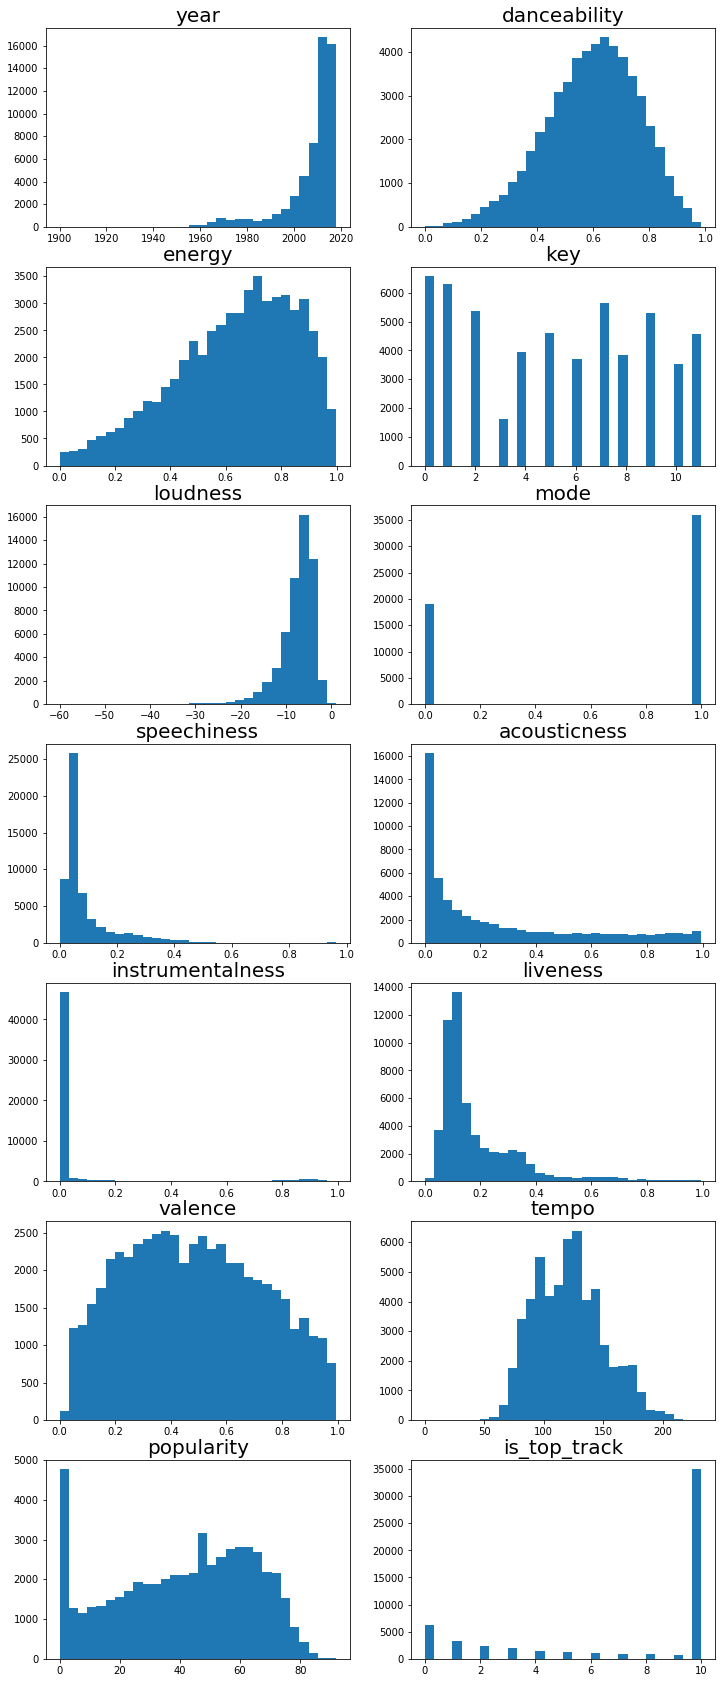

In [28]:
fig, ax = plt.subplots(7, 2, figsize = (12,30))

cnt = 0
for i in range(7):
    for j in range(2):
        ax[i,j].hist(playlists_df_full_section3_4[feature_lists[cnt]].dropna(), bins=30)
        ax[i,j].set_title(feature_lists[cnt], fontsize=20)
        cnt = cnt +1

- In general, these distributions are similar to the distributions in 1.(2), which presented by Spotify, indicating our 55000 samples reasonably represent the whole population.

- Below, we have generated the inter-dependency plot, by defining a custon function `draw_inter_dependencies`:

In [29]:
def draw_inter_dependencies(feature_arg, title_arg : str):
    '''
    Input
        feature_arg : feature data of which we will draw distribution
        title_arg : title of the plot
    '''
    ax = scatter_matrix(feature_arg, alpha=0.2, figsize=(18,20), diagonal='kde', range_padding = 0.25)

    for aa in np.arange(ax.shape[0]):
        for bb in np.arange(ax.shape[1]):
            ax[aa,bb].tick_params(labelsize=12)
            ax[aa,bb].tick_params(axis='both', labelrotation=45)
            ax[aa,bb].xaxis.label.set_size(15)
            ax[aa,bb].yaxis.label.set_size(15)
            
            if (bb % 2 == 0):
                ax[aa,bb].xaxis.set_label_coords(0.5,-0.5)
            else:
                ax[aa,bb].xaxis.set_label_coords(0.5,-0.75)
            if (aa % 2 == 0):
                ax[aa,bb].yaxis.set_label_coords(-0.75,0.5)
            else:
                ax[aa,bb].yaxis.set_label_coords(-1.0,0.5)

    plt.suptitle(title_arg, fontsize=25,y=0.9);

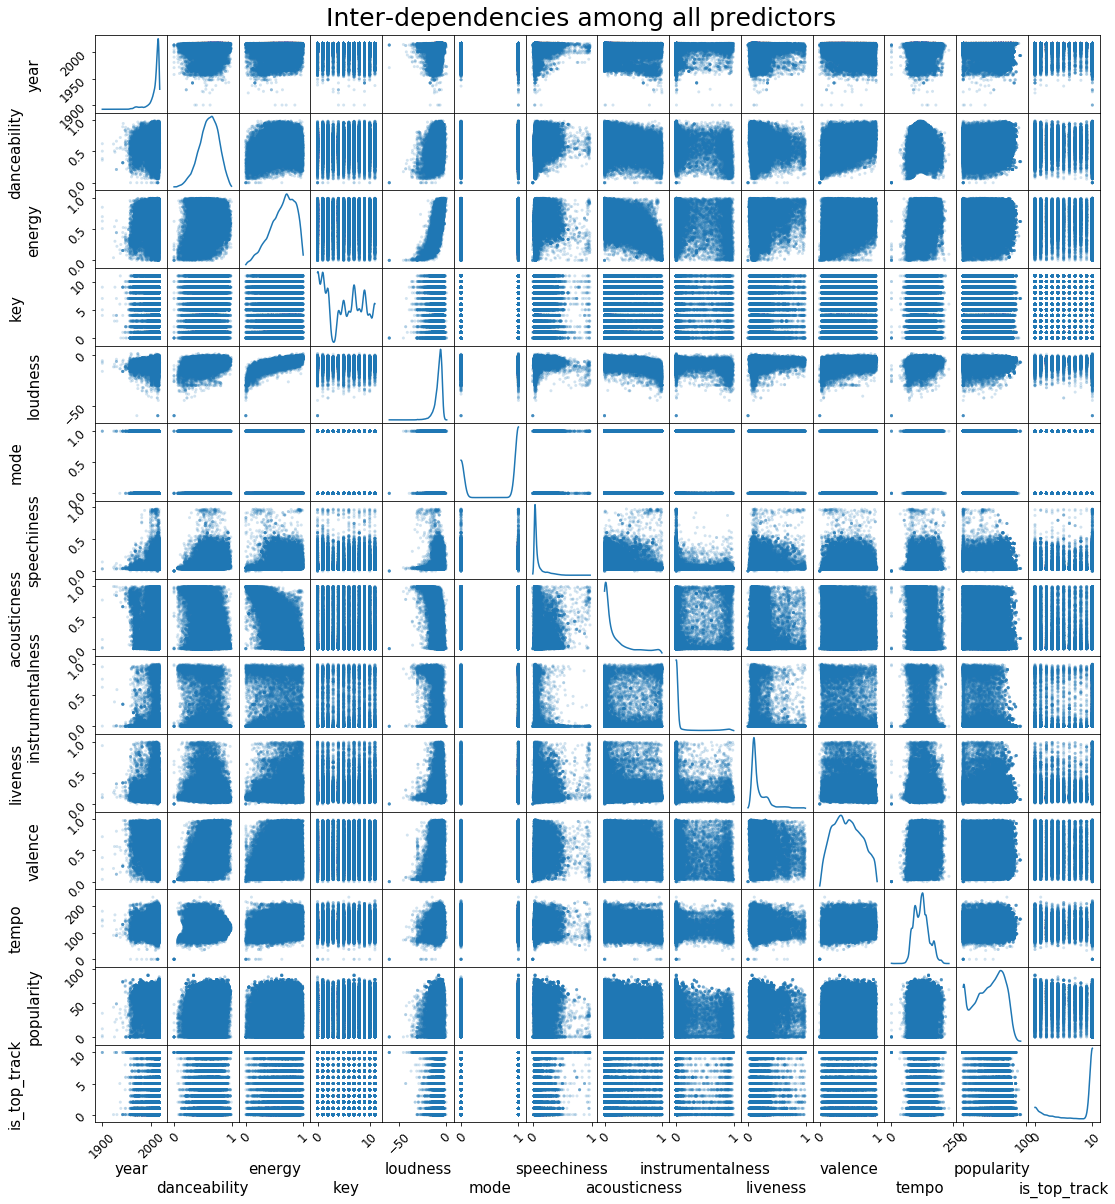

In [30]:
draw_inter_dependencies(playlists_df_full_section3_4[feature_lists], 'Inter-dependencies among all predictors')

- As shown above, although there seems to be some interdependency between metrics, most likely they distribute widely to each other.

- As for categorical variables, we have included genres of the artist. The distribution of genres for the entire 55000 tracks is like below:

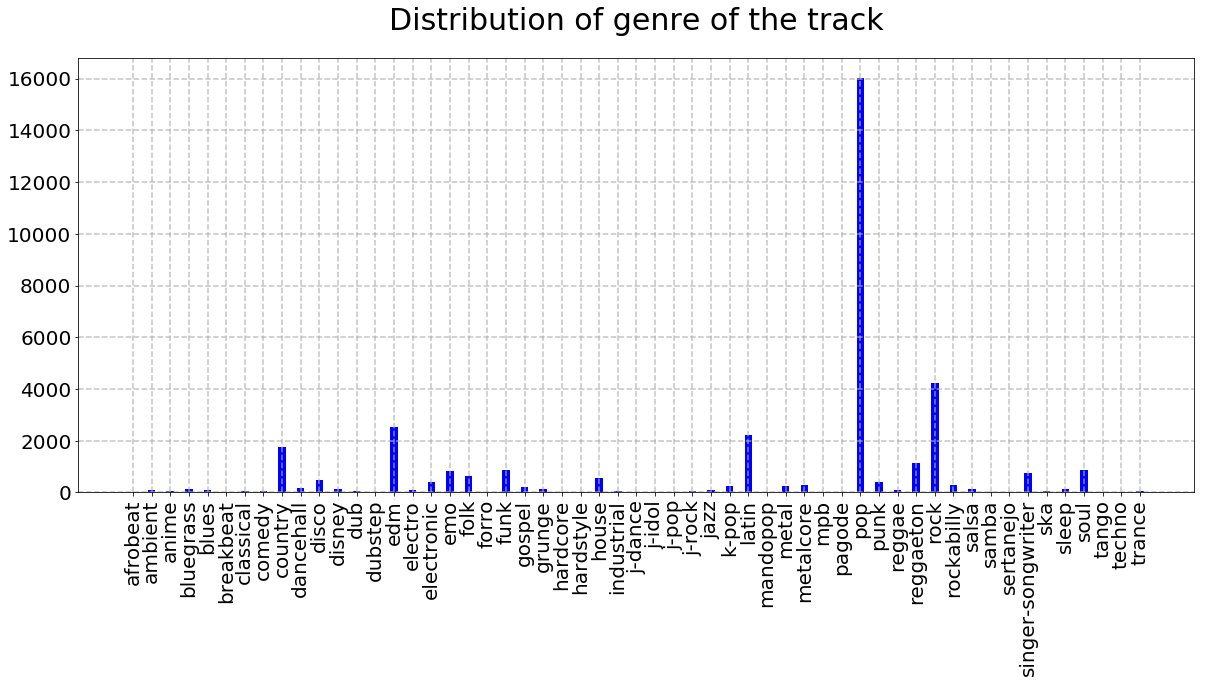

In [31]:
genre_lists = sp.recommendation_genre_seeds()['genres']
nonzero_genre_temp = (np.sum(playlists_df_full_section3_4[genre_lists]) != 0)
nonzero_genre = [ele for ele in nonzero_genre_temp[nonzero_genre_temp.values].index]

fig, ax = plt.subplots(1, 1, figsize = (20, 8))

ind = np.arange(len(nonzero_genre))
ax.bar(ind, playlists_df_full_section3_4[nonzero_genre].sum().values, 0.4, color='b')

ax.tick_params(labelsize = 20)
ax.tick_params(axis='x', rotation = 90)
ax.set_xticks(ind)
ax.set_xticklabels(nonzero_genre, fontsize=5)

ax.grid(True, lw =  1.5, ls = '--', alpha = 0.75)
ax.set_title('Distribution of genre of the track', fontsize=30, y = 1.05);

- As shown above, the `pop` genre is predominant against the other genres, taking 30% of the entire data points, but still there are other genres that have significant number of tracks.


- More interestingly, we can plot the distribution of the genre within each playlist, so that we can see a possibiliyt of discriminating playlists by looking at their genres. Below shows the distribution of the genres of the first 20 playlists.

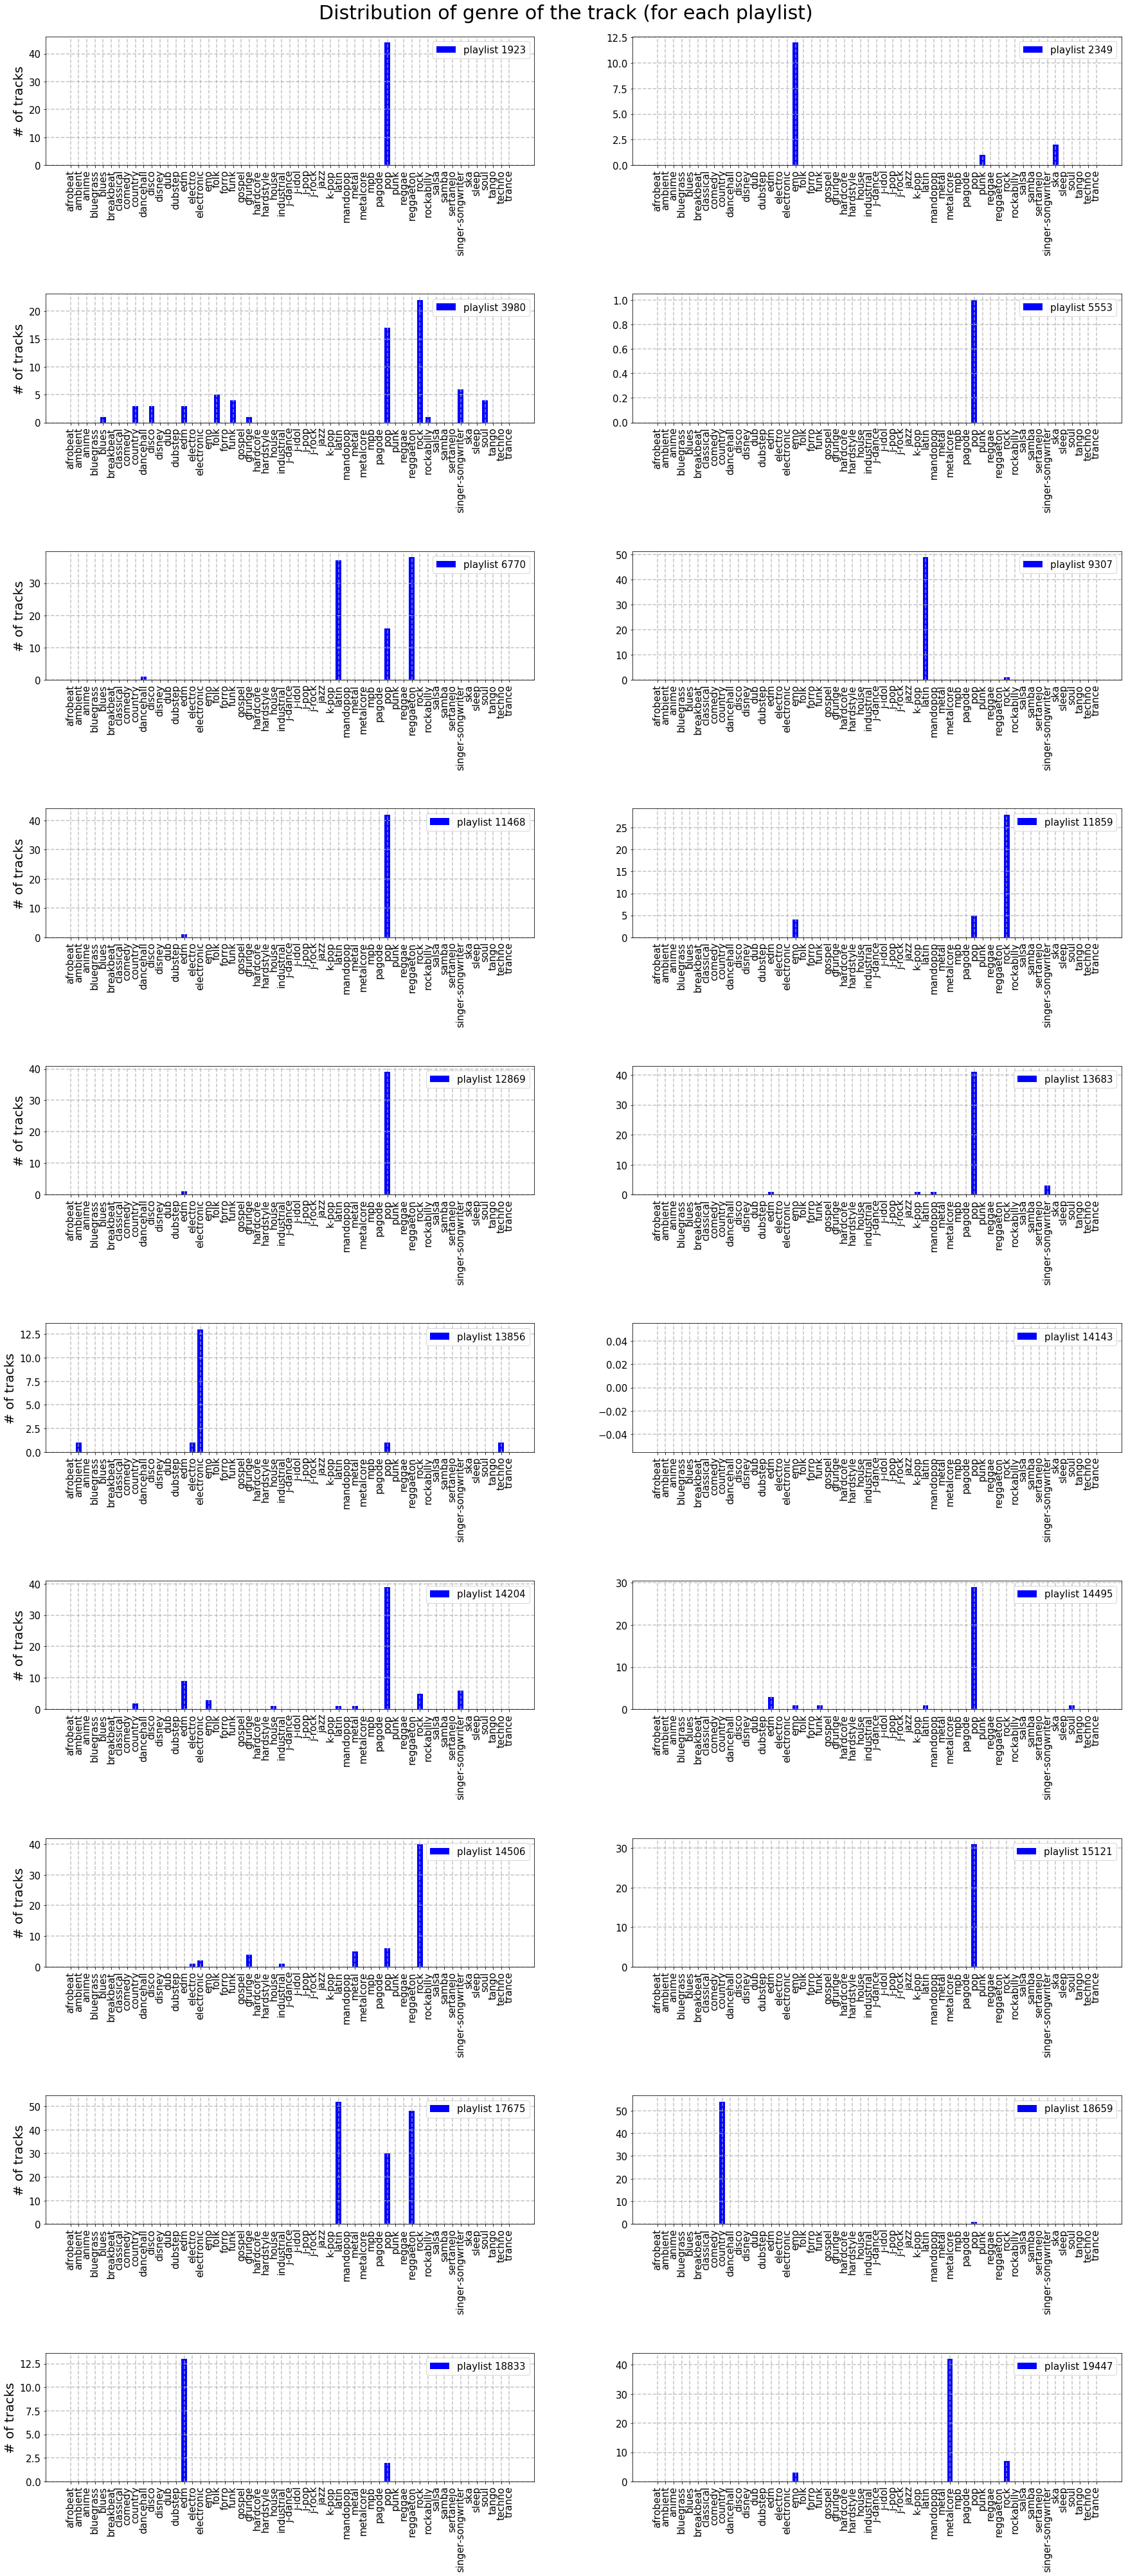

In [32]:
fig, ax = plt.subplots(10, 2, figsize = (30, 70))
plt.subplots_adjust(hspace = 1.0)

ind = np.arange(len(nonzero_genre))
width = 0.7

cnt = 0
for pid in playlists_df_full_section3_4.groupby('pid').sum()[nonzero_genre].index[:20]:

    ax_temp = ax[cnt//2, cnt%2]
    ax_temp.bar(ind, playlists_df_full_section3_4.groupby('pid').sum()[nonzero_genre].loc[pid].values, 
           width, color='b', label = 'playlist ' + str(pid))
    
    ax_temp.tick_params(labelsize = 15)
    ax_temp.tick_params(axis='x', rotation = 90)
    if cnt == len(nonzero_genre)-1:
        ax_temp.set_xticks(ind)
    
    # Make labels
    if cnt%2 == 0:
        ax_temp.set_ylabel('# of tracks',fontsize=20)
    ax_temp.set_xticks(ind)
    ax_temp.set_xticklabels(nonzero_genre, fontsize=3)
    
    ax_temp.legend(fontsize=15)
    ax_temp.grid(True, lw =  1.5, ls = '--', alpha = 0.75)
    
    cnt += 1

fig.suptitle('Distribution of genre of the track (for each playlist)', fontsize=30, y = 0.89);

- As shown above, each playlist has a distinct distribution of genres. For example,
    - For most playlists, the `pop` genre is predominant. However,
    - For playlist 2349, the `emo` genre (a rock music genre characterized by an emphasis on emotional expression) is predominant.
    - For playlist 13856, the `electronics` genre is predominant.
    - For playlist 14506, the `rock` genre is predominant.
    - For playlist 18659, the `country` genre is predominant.
    - For playlist 18833, the `edm` genre is predominant.
    - For playlist 19447, the `metalcore` genre is predominant.


- Thus, we may predict that a song with genre of `metalcore` is likely to be in the playlist 19447, which is very promising.